<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo">
</center>

# Gradient Boosting  for classification with Python

Estimated time needed: **1.45** hours


In this notebook, you will learn Gradient Boosting for classification; AdaBoost is a particular case of Gradient Boosting and an additive model where we add weak learners to minimize the loss function. This lab will focus on <a href="https://xgboost.readthedocs.io/en/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01">XGBoost</a>, an open-source software library that provides a regularizing gradient boosting framework.  XGBoost can use different types of weak learners called boosters for classification and regression. We will focus on trees for classification.


Unlike Bagging and Random Forest, Gradient Boosting can cause overfitting. As a result, Gradient Boosting requires Hyperparameter tuning, taking more time to train. One advantage of Gradient Boosting is that each classifier is smaller, so predictions are faster in Gradient Boosting.
AdaBoost is a subclass of Gradient Boosting; one weakness of AdaBoost is that misclassified samples cause overfitting; Gradient Boosting uses different loss functions, reducing this effect.
The following table show's the Average accuracy and standard deviation for the Random Forest (RF), gradient boosting (GB) and XGBoost, both using the default (D) and (T) tuned parameter settings, we see that XGBoost does best, followed by GB outperforming the other methods.


## **Table of Contents**

​

<!-- <a href="#Multi-Dimensional_Scaling">Multi-Dimensional Scaling/a> -->

<ol>
<li style="list-style-type: none;">
<ol>
<li>Objectives</li>
<li>Setup
<ol>
<li>Installing Required Libraries&lt;</li>
<li>Importing Required Libraries</li>
<li>Defining Helper Functions</li>
</ol>
</li>
<li>How  Gradient Boosting  Works (Optional)
    <ol>
    <li> How to Minimize Cost</li>
    <li>  Example with Python </li>
    </ol>

<li>Xgboost<br />
<ol>
<li>About the dataset</li>
<li>Gradient Boosting parameter</li>
 <li>Evaluation Metric on Second Dataset </li>
    <li>Early Stopping </li>
    <li>Parameters for Trees </li>

</ol>
</li>
<li>Cancer Data Example with GridSearchCV</li>
<li>Practice</li>
</ol>
</li>
</ol>


## Objectives

After completing this lab you will be able to:

*   Understand   Gradient Boosting  is a linear combination of  𝑇 weak classifiers
*   Apply Gradient Boosting using  XGBoost,
*   Understand Hyperparameters selection in  XGBoost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return {
        'test accuracy': accuracy_score(y_test, model.predict(X_test)),
        'train accuracy': accuracy_score(y_train, model.predict(X_train))
    }

In [24]:
def get_accuracy_boost(X, y, title, times, xlabel='Num Estimators', learning_rate=[0.2, 0.4, 0.6, 1.0], n_est=100):
    lines_array = ['solid', '--', '-.', ':']
    n_estimators = [n * 2 for n in range(1, n_est // 2)]
    acc_shape = (times, len(learning_rate), len(n_estimators))
    train_acc = np.zeros(acc_shape)
    test_acc = np.zeros(acc_shape)
    
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        for n_trees in n_estimators:
            for j, lr in enumerate(learning_rate):
                model = XGBClassifier(objective=objective,
                                      learning_rate=lr,
                                      n_estimators=n_trees,
                                      eval_metric='mlogloss')
                model.fit(X_train, y_train)
                accuracy = get_accuracy(X_train, X_test, y_train, y_test, model)
                train_acc[n, j, (n_trees // 2) - 1] = accuracy['train accuracy']
                test_acc[n, j, (n_trees // 2) - 1] = accuracy['test accuracy']
    
    fig, ax1 = plt.subplots()
    mean_test = test_acc.mean(axis=0)
    mean_train = train_acc.mean(axis=0)
    ax2 = ax1.twinx()
    
    for j, (lr, line) in enumerate(zip(learning_rate, lines_array)):
        ax1.plot(mean_train[j, :], linestyle=line, color='b', label=f"Learning Rate {lr}")
        ax2.plot(mean_test[j, :], linestyle=line, color='r', label=str(lr))

    ax1.set_ylabel('Training Accuracy', color='b')
    ax1.legend()
    ax2.set_ylabel('Testing Accuracy', color='r')
    ax2.legend()
    ax1.set_xlabel(xlabel)
    plt.show()

# Xgboost

### About the dataset

We will use a telecommunications dataset for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically, it is less expensive to keep customers than to acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.

This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

The dataset includes information about:

*   Customers who left within the last month – the column is called Churn
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
*   Customer account information – how long they had been a customer, contract, payment method, paperless billing, monthly charges, and total charges
*   Demographic info about customers – gender, age range, and if they have partners and dependents


In [6]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv")
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


In [7]:
churn_df.dtypes

tenure      float64
age         float64
address     float64
income      float64
ed          float64
employ      float64
equip       float64
callcard    float64
wireless    float64
longmon     float64
tollmon     float64
equipmon    float64
cardmon     float64
wiremon     float64
longten     float64
tollten     float64
cardten     float64
voice       float64
pager       float64
internet    float64
callwait    float64
confer      float64
ebill       float64
loglong     float64
logtoll     float64
lninc       float64
custcat     float64
churn       float64
dtype: object

In [8]:
(churn_df.max() == 1).all()

False

### Data pre-processing and selection

Let's select some features for the modeling. Also, we change the target data type to be an integer, as it is a requirement by the skitlearn algorithm:

In [9]:
FEATURE_COLUMNS = ['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']
Y_COLUMN = 'churn'

In [10]:
X = churn_df[FEATURE_COLUMNS].astype(int)
y = churn_df[Y_COLUMN].astype(int)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
n_estimators = 5
random_state = 0
objective = 'binary:logistic'
learning_rate = 0.1

`objective` :  Specify the learning task and the corresponding learning objective or a custom objective function to be used.
For example:

`binary:logistic`: binary classification

`multi:softprob`:multi-class classification


`learning_rate` : Boosting learning rate, also called `eta`


The `booster` parameter sets the type of learner, in this lab we will stick with trees. Let's experiment with some of the Gradient Boosting parameter:


In [13]:
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    eval_metric='mlogloss'
)

If the outputs were y is -1 and 1, the form of the classifier would be, but `xgboost` will convert it to the same as the label `y`

$H(x) = 	ext{sign}(   h_1(x)+  h_2(x)+ h_3(x)+  h_4(x)+  h_5(x) )$

Unlike AdaBoost there is not $\alpha_t$, but there are some versions that have a similar term. We can fit all $H(x)$ and then make a prediction:


$H(x) = 	ext{sign}(   h_1(x)+  h_2(x)+ h_3(x)+  h_4(x)+  h_5(x) )$

In [14]:
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test accuracy': 0.75, 'train accuracy': 0.7785714285714286}


In [16]:
learning_rate = 0.3

In [17]:
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The learning rate is a hyperparameter. In this case we see by increasing the learning rate, we get better accuracy on the training and test data.

In [18]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test accuracy': 0.75, 'train accuracy': 0.9142857142857143}


This is unusual, usually a high learning rate causes overfitting. Another parameter is `n_estimators` and is the number of classifiers. Increasing the number of classifiers increases overfitting.


In [19]:
n_estimators = 100
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test accuracy': 0.7, 'train accuracy': 1.0}


100%|██████████| 10/10 [00:35<00:00,  3.59s/it]


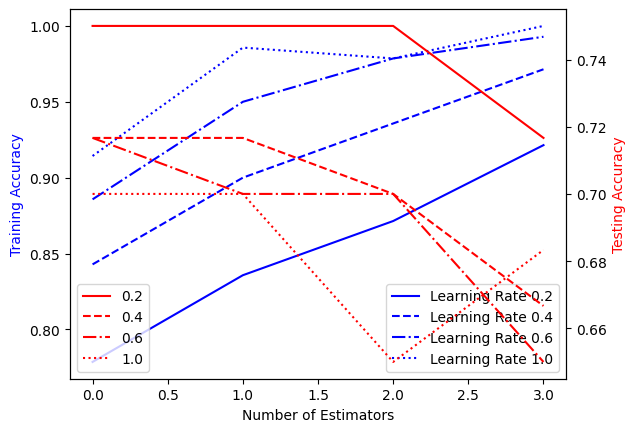

In [25]:
get_accuracy_boost(X, y, title='Training and Test Accuracy vs Weak Classifiers', times=10, xlabel='Number of Estimators', n_est=10)

### Evaluation Metric on Second Dataset

We can input a  `eval_metric`  parameter  in the `fit` method; this  determines how the model performs on each iteration using a second dataset; in XG Boost the metrics include:

`logloss` : binary logarithmic loss

`mlogloss` cross entropy loss

`error` : number of misclassified samples

`auc` : area under  ROC curve (receiver operating characteristic curve)

We will use `error`:


In [26]:
eval_metric = 'error'

In [27]:
eval_set = [(X_test, y_test)]

In [31]:
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    eval_metric=eval_metric,
)
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.25000
[1]	validation_0-error:0.25000
[2]	validation_0-error:0.26667
[3]	validation_0-error:0.28333
[4]	validation_0-error:0.25000
[5]	validation_0-error:0.28333
[6]	validation_0-error:0.28333
[7]	validation_0-error:0.28333
[8]	validation_0-error:0.28333
[9]	validation_0-error:0.28333
[10]	validation_0-error:0.28333
[11]	validation_0-error:0.28333
[12]	validation_0-error:0.33333
[13]	validation_0-error:0.31667
[14]	validation_0-error:0.35000
[15]	validation_0-error:0.31667
[16]	validation_0-error:0.33333
[17]	validation_0-error:0.31667
[18]	validation_0-error:0.33333
[19]	validation_0-error:0.30000
[20]	validation_0-error:0.35000
[21]	validation_0-error:0.31667
[22]	validation_0-error:0.31667
[23]	validation_0-error:0.31667
[24]	validation_0-error:0.31667
[25]	validation_0-error:0.30000
[26]	validation_0-error:0.30000
[27]	validation_0-error:0.28333
[28]	validation_0-error:0.30000
[29]	validation_0-error:0.31667
[30]	validation_0-error:0.30000
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
results = model.evals_result()
print(results)

{'validation_0': OrderedDict([('error', [0.25, 0.25, 0.26666666666666666, 0.2833333333333333, 0.25, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.3333333333333333, 0.31666666666666665, 0.35, 0.31666666666666665, 0.3333333333333333, 0.31666666666666665, 0.3333333333333333, 0.3, 0.35, 0.31666666666666665, 0.31666666666666665, 0.31666666666666665, 0.31666666666666665, 0.3, 0.3, 0.2833333333333333, 0.3, 0.31666666666666665, 0.3, 0.3, 0.3, 0.31666666666666665, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2833333333333333, 0.3, 0.3, 0.3, 0.2833333333333333, 0.3, 0.3, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333333333333, 0.2833333

Text(0, 0.5, 'Misclassified Samples')

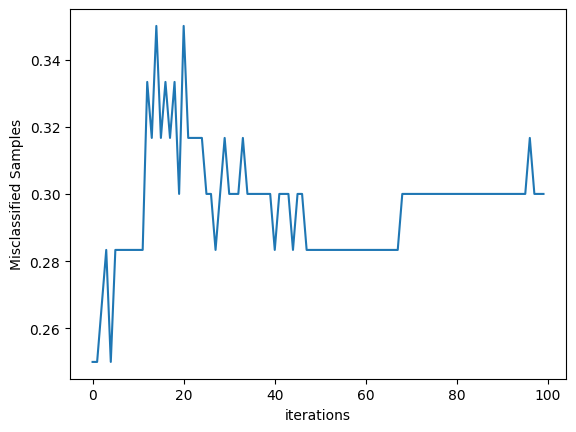

In [33]:
plt.plot(range(0, len(results['validation_0']['error'])), results['validation_0']['error'])
plt.xlabel('iterations')
plt.ylabel('Misclassified Samples')

We can input multiple datasets, for example we can input the training and test data and use the metric `logloss`.

In [34]:
eval_metric = 'logloss'
eval_set = [(X_train, y_train), (X_test, y_test)]
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    eval_metric=eval_metric
)
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.50799	validation_1-logloss:0.53671
[1]	validation_0-logloss:0.43492	validation_1-logloss:0.52898
[2]	validation_0-logloss:0.38449	validation_1-logloss:0.51844
[3]	validation_0-logloss:0.34118	validation_1-logloss:0.51210
[4]	validation_0-logloss:0.31266	validation_1-logloss:0.50325
[5]	validation_0-logloss:0.28766	validation_1-logloss:0.51104
[6]	validation_0-logloss:0.26879	validation_1-logloss:0.52472
[7]	validation_0-logloss:0.24638	validation_1-logloss:0.53262
[8]	validation_0-logloss:0.22898	validation_1-logloss:0.54213
[9]	validation_0-logloss:0.21343	validation_1-logloss:0.54848
[10]	validation_0-logloss:0.19915	validation_1-logloss:0.56352
[11]	validation_0-logloss:0.18799	validation_1-logloss:0.56828
[12]	validation_0-logloss:0.17551	validation_1-logloss:0.57229
[13]	validation_0-logloss:0.16654	validation_1-logloss:0.57443
[14]	validation_0-logloss:0.15915	validation_1-logloss:0.58255
[15]	validation_0-logloss:0.15199	validation_1-logloss:0.58165
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [37]:
results = model.evals_result()

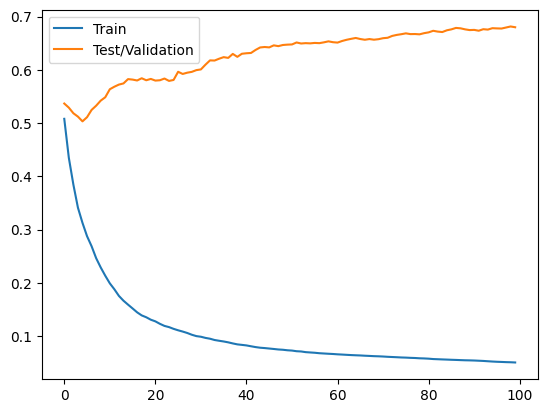

In [38]:
fig, ax = plt.subplots()
ax.plot(results['validation_0']['logloss'], label='Train')
ax.plot(results['validation_1']['logloss'], label='Test/Validation')
ax.legend()
plt.show()

We see that the training error decreases for each epoch in blue, but the validation error flattens then increases; this is a sign of overfitting. We can reduce this by early stopping.


### Early Stopping

Early Stopping is a way to prevent overfitting; we stop gradient descent based on a specified number of epochs over which no improvement is observed using the evaluation set . The input parameter is  `early_stopping_rounds`.

In [39]:
early_stopping_rounds = 10

In [41]:
eval_set = [(X_test, y_test)]
eval_metric = 'logloss'
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    eval_metric=eval_metric
)
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.53671
[1]	validation_0-logloss:0.52898
[2]	validation_0-logloss:0.51844
[3]	validation_0-logloss:0.51210
[4]	validation_0-logloss:0.50325
[5]	validation_0-logloss:0.51104
[6]	validation_0-logloss:0.52472
[7]	validation_0-logloss:0.53262
[8]	validation_0-logloss:0.54213
[9]	validation_0-logloss:0.54848
[10]	validation_0-logloss:0.56352
[11]	validation_0-logloss:0.56828
[12]	validation_0-logloss:0.57229
[13]	validation_0-logloss:0.57443
[14]	validation_0-logloss:0.58255
[15]	validation_0-logloss:0.58165
[16]	validation_0-logloss:0.57996
[17]	validation_0-logloss:0.58417
[18]	validation_0-logloss:0.58039
[19]	validation_0-logloss:0.58290
[20]	validation_0-logloss:0.57979
[21]	validation_0-logloss:0.58041
[22]	validation_0-logloss:0.58361
[23]	validation_0-logloss:0.57918
[24]	validation_0-logloss:0.58096
[25]	validation_0-logloss:0.59630
[26]	validation_0-logloss:0.59222
[27]	validation_0-logloss:0.59461
[28]	validation_0-logloss:0.59615
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [42]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test accuracy': 0.7, 'train accuracy': 1.0}


### Parameters for Trees

In [50]:
objective = 'binary:logistic'
eval_metric = 'mlogloss'
learning_rate = 0.1
n_estimators = 10
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    eval_metric=eval_metric
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [51]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test accuracy': 0.75, 'train accuracy': 0.8571428571428571}


In [52]:
max_depth = 3

In [53]:
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    eval_metric=eval_metric,
    max_depth=max_depth
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [54]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test accuracy': 0.8, 'train accuracy': 0.8}


In [55]:
min_child_weight = 4

In [58]:
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    eval_metric=eval_metric,
    min_child_weight=min_child_weight
)
model.fit(X_train, y_train)
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test accuracy': 0.8166666666666667, 'train accuracy': 0.8}


In [59]:
gamma = 1
reg_lambda = 2
alpha = 1
model = XGBClassifier(
    objective=objective,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    eval_metric=eval_metric,
    gamma=gamma,
    reg_lambda=reg_lambda,
    alpha=alpha
)
model.fit(X_train, y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, ...)

In [60]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test accuracy': 0.8, 'train accuracy': 0.7857142857142857}
